Import packages

In [1]:
from utils import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Reshape, LSTM, TimeDistributed, Permute
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import datetime

Load dataset

In [2]:
X_train, y_train, X_test, y_test = init_data(subject=None, verbose=True)
X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=True)
x_train_aug, y_train_aug, x_valid_aug, y_valid_aug, x_test_aug, y_test_aug = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=True)

Training data shape: (7616, 22, 250) Training target shape: (7616,)
Testing data shape: (443, 22, 250) Testing target shape: (443,)
Training data shape: (7616, 250, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 250, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 250, 1, 22) Testing target shape: (443, 4)


Initial model structure

In [18]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(15,1), padding='same', activation='elu', input_shape=(250,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(15,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(15,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# # Conv. block 4
# hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(15,1), padding='same', activation='elu'))
# hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
# hybrid_cnn_lstm_model.add(BatchNormalization())
# hybrid_cnn_lstm_model.add(Dropout(0.5))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
# hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.5, recurrent_dropout=0.1, return_sequences=True))

hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.5, recurrent_dropout=0.1))
# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()





Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 250, 1, 25)        8275      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 84, 1, 25)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 84, 1, 25)        100       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 84, 1, 25)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 84, 1, 50)         18800     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 1, 50)       

In [19]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [20]:
!rm -rf ./logs/

In [21]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 29493), started 6:07:16 ago. (Use '!kill 29493' to kill it.)

In [22]:
# !kill 33800

In [23]:
# Model parameters
learning_rate = 0.001
epochs = 90
hybrid_cnn_lstm_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,weight_decay=1e-5)

# create a tensorboard callback to visualize training
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

# anneals the learning rate
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.1)  # reduces by a factor of 10 if validation loss doesn't improve for 10 epochs


# early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

# checkpoint saving callback
save_cb = tf.keras.callbacks.ModelCheckpoint(
    'models/checkpoint_{epoch:02d}_{val_loss:0.2f}',   # where to save models
    monitor= 'val_loss',
    verbose = 0,
    save_best_only = False,
    save_weights_only = False,
    save_freq='epoch'   # saves every epoch
)

Compile and train the model

In [24]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'],
                )

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train_aug,
             y_train_aug,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_aug, y_valid_aug), verbose=True,
             callbacks=[tb_callback, early_stopping_cb]
             )


Epoch 1/90
119/119 [==============================] - 6s 41ms/step - loss: 1.3635 - accuracy: 0.2969 - val_loss: 1.3269 - val_accuracy: 0.3187
Epoch 2/90
119/119 [==============================] - 4s 33ms/step - loss: 1.3038 - accuracy: 0.3566 - val_loss: 1.2901 - val_accuracy: 0.3863
Epoch 3/90
119/119 [==============================] - 4s 35ms/step - loss: 1.2628 - accuracy: 0.3890 - val_loss: 1.2650 - val_accuracy: 0.4206
Epoch 4/90
119/119 [==============================] - 4s 34ms/step - loss: 1.2273 - accuracy: 0.4256 - val_loss: 1.2630 - val_accuracy: 0.4017
Epoch 5/90
119/119 [==============================] - 4s 32ms/step - loss: 1.2025 - accuracy: 0.4361 - val_loss: 1.2565 - val_accuracy: 0.4182
Epoch 6/90
119/119 [==============================] - 4s 31ms/step - loss: 1.1770 - accuracy: 0.4630 - val_loss: 1.2200 - val_accuracy: 0.4147
Epoch 7/90
119/119 [==============================] - 4s 31ms/step - loss: 1.1541 - accuracy: 0.4783 - val_loss: 1.2096 - val_accuracy: 0.4135

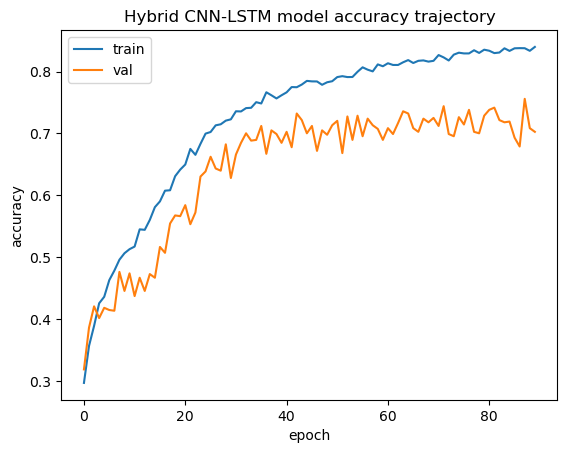

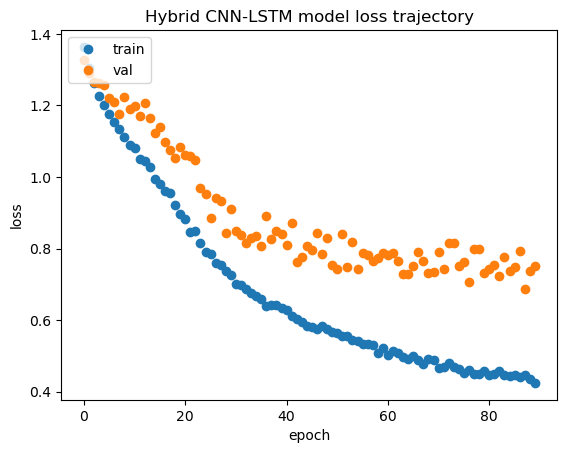

In [25]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test_aug, y_test_aug, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.7200902700424194
